In [45]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [46]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [47]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [48]:
%matplotlib inline

In [49]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(17646, 28)
(17646, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [50]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [51]:
# Entries where RR supports
idxs = np.where(X_relative_footsteps_acc[:, 24] == 0)[0]
X_relative_footsteps_acc_RR_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_RR_support = Y_relative_footsteps_acc[idxs]

## Predict RR foot -> x

In [52]:
X_relative_footsteps_acc_RR_support.shape

(8795, 28)

In [53]:
X_relative_footsteps_acc_RR_support[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.04003644, -0.06632428,
        0.05440154,  0.00439207,  0.02899047,  0.02653936,  0.22664036,
        0.18001143, -0.4086564 ,  0.23994108, -0.16991884, -0.40835668,
       -0.2385218 ,  0.16382314, -0.41169444, -0.25160387, -0.15317046,
       -0.41252498,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [54]:
Y_relative_footsteps_acc_RR_support[0, :]

array([ 0.22800851,  0.17177425,  0.23270544, -0.17693889, -0.24620022,
        0.1547656 , -0.24999362, -0.16156544])

### Linear Regression

In [61]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_x = LinearRegression()

# Fit the model
model_rr_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8719352597430945
RMSE:  0.005772560455568328
The lowest error is:  4.683106949732174e-07
The highest error is:  0.05135365933938993
The avg. error is:  0.0030766057086867313


In [64]:
model_rr_relative_support_x.coef_

array([[ 0.00486416,  0.00119608, -0.01193982,  0.10531773, -0.00144003,
        -0.0012512 , -0.11169108,  0.00078995, -0.09171185, -0.10997794,
         0.14711624,  0.14439952,  0.44424135, -0.05127216]])

In [62]:
model_rr_relative_support_x.intercept_

array([-0.10838893])

Text(0, 0.5, 'Predictions')

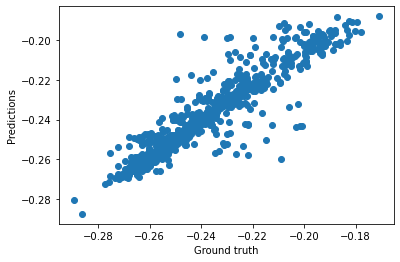

In [63]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#%store model_rr_relative_support_x

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [22]:
# Save model
#joblib.dump(model_rr_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_x.sav")

### Predict FL foot -> y

In [70]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_y = LinearRegression()

# Fit the model
model_rr_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9229842379890525
RMSE:  0.008788560020659269
The lowest error is:  1.9451563397498983e-06
The highest error is:  0.04944223863418479
The avg. error is:  0.005678023418337383


In [73]:
model_rr_relative_support_y.coef_

array([[ 0.01496668, -0.01973009,  0.03339225, -0.00206447,  0.10296279,
         0.1261246 , -0.11742698,  0.03805601,  0.39789799,  0.51792289,
        -0.52083761, -0.05243376,  0.14959623,  0.64207263]])

In [71]:
model_rr_relative_support_y.intercept_

array([-0.12937615])

Text(0, 0.5, 'Predictions')

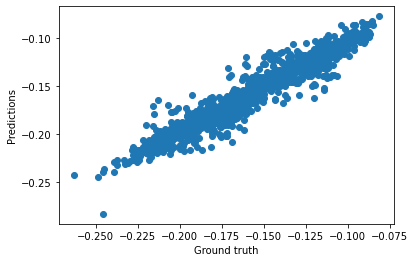

In [72]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [42]:
#%store model_rr_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_rr_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_y.sav")